In [1]:
import io
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from AutoML import AutomatedRegression

In [2]:
# TODO add more data where pulse compression is performed?
# TODO add cross poll if sentinel-xarray has noise floor
# TODO use training data from half the image and apply on the other

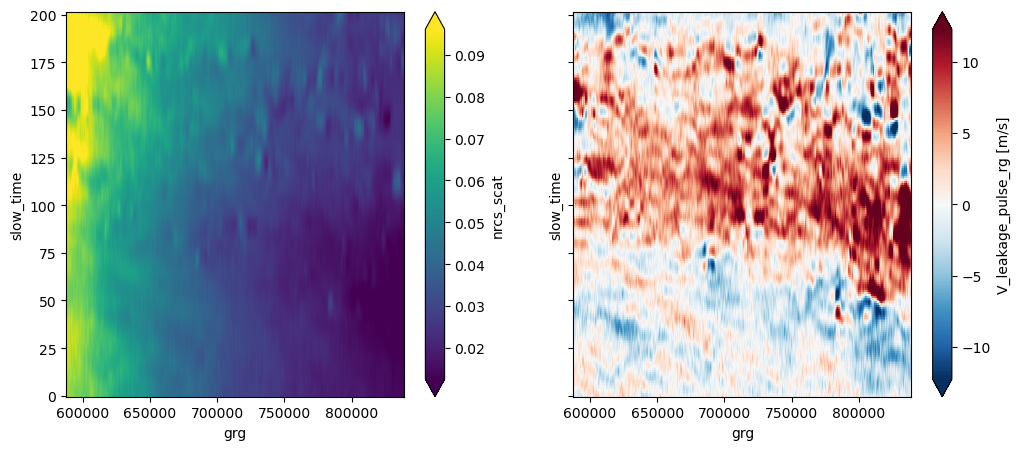

In [7]:
data = xr.open_dataset('scatt4ML.nc')
data = data.dropna(dim= 'slow_time', how = 'all').dropna(dim='grg', how='any')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
data.nrcs_scat.T.plot(robust=True, ax = axes[0])
data.V_leakage_pulse_rg.T.plot(robust=True, ax = axes[1])

In [7]:
n = 15
X = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder').values.reshape(-1, 2*n+1)
y = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder').values.reshape(-1)

In [8]:
ML = AutomatedRegression(
    X=X,
    y=y,
    n_trial=50,
    models_to_optimize=['bayesianridge', 'lightgbm'],
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/n_15_V_split_scene_traintest/',
)

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))


In [33]:
X_t = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
y_t = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')

N = 50
test = (0, N);
train = (N + 2*n+1, X_t['placeholder'].shape[0])

X_test = pd.DataFrame(X_t.isel(placeholder=range(*test)).values.reshape(-1, 2*n+1))
X_train = pd.DataFrame(X_t.isel(placeholder=range(*train)).values.reshape(-1, 2*n+1))
y_test = pd.DataFrame(y_t.isel(placeholder=range(*test)).values.reshape(-1))
y_train = pd.DataFrame(y_t.isel(placeholder=range(*train)).values.reshape(-1))

print(X_test.shape, X_train.shape, y_test.shape, y_train.shape )

ML.X_test = X_test
ML.X_train = X_train
ML.y_test = y_test 
ML.y_train = y_train 

(37000, 31) (67340, 31) (37000, 1) (67340, 1)


In [34]:

# hideous warning catcher
with warnings.catch_warnings(record=True) as caught_warnings:
    output_buffer = io.StringIO()
    sys.stdout = output_buffer

    result = ML.apply()
    
sys.stdout = sys.__stdout__

[I 2023-11-17 12:20:07,346] A new study created in RDB with name: regression_bayesianridge
[I 2023-11-17 12:20:09,164] Trial 0 finished with value: -1.573031730167345 and parameters: {'scaler': 'minmax', 'n_iter': 71, 'tol': 15.59945204206032, 'alpha_1': 3.809220577048033e-08, 'alpha_2': 4.589458612326476, 'lambda_1': 0.010260065124896783, 'lambda_2': 0.12042752972516813, 'transformers': 'quantile_trans', 'n_quantiles': 3400}. Best is trial 0 with value: -1.573031730167345.
[I 2023-11-17 12:20:18,504] Trial 1 finished with value: -1.5729371976512743 and parameters: {'scaler': 'robust', 'n_iter': 215, 'tol': 43.19450186989213, 'alpha_1': 8.171304639059403e-06, 'alpha_2': 0.013137990612765096, 'lambda_1': 2.4827821051950883e-07, 'lambda_2': 8.345387083873532e-06, 'transformers': 'quantile_trans', 'n_quantiles': 3200}. Best is trial 1 with value: -1.5729371976512743.
[I 2023-11-17 12:20:20,127] Trial 2 finished with value: 0.7551526157358439 and parameters: {'scaler': 'standard', 'n_iter'

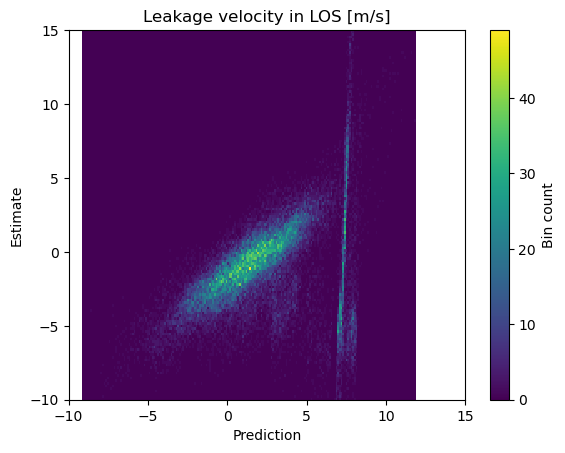

{'bayesianridge_best': [[2.2647568899578543, 0.01728062600273567],
  [-0.06100890936212946, 0.017628807461398204]],
 'lightgbm_best': [[2.6970071738890495, 0.02246926777169777],
  [-1.4155853728253125, 0.054885543628694834]],
 'stacked': [[2.4543298099978528, 0.022424993163800987],
  [-1.1533619441115632, 0.04857350440597856]]}

In [35]:
plt.hist2d(ML.y_pred, np.ravel(ML.y_test.values), bins=(200,200)) #, gridsize=10, cmap='Blues', edgecolors='gray', mincnt=1)
plt.xlim([-10, 15]); plt.ylim([-10, 15])
plt.colorbar(label='Bin count')
plt.title('Leakage velocity in LOS [m/s]')
plt.xlabel('Prediction')
plt.ylabel('Estimate')
plt.show()

ML.summary

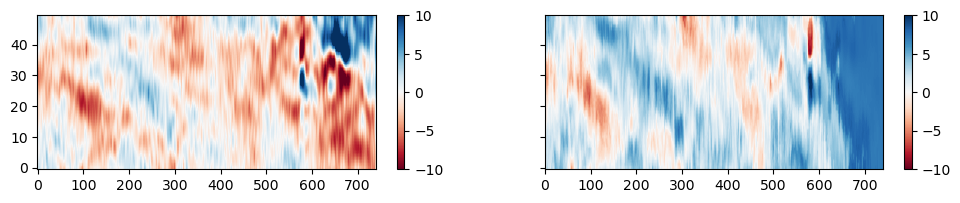

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 2), sharex=True, sharey=True)
vmin = -10;
vmax = 10
im0 = axes[0].imshow(ML.y_test.values.reshape((N, -1)), origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')

im1 = axes[1].imshow(ML.y_pred.reshape((N, -1)), origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im0, ax=axes[0])


## Considering fewer along azimuth points

In [21]:
n = 5
X = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder').values.reshape(-1, 2*n+1)
y = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder').values.reshape(-1)

ML2 = AutomatedRegression(
    X=X,
    y=y,
    n_trial=50,
    models_to_optimize=['bayesianridge', 'lightgbm'],
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/n_5_V/',
)

# hideous warning catcher
with warnings.catch_warnings(record=True) as caught_warnings:
    output_buffer = io.StringIO()
    sys.stdout = output_buffer

    result = ML2.apply()
    
sys.stdout = sys.__stdout__

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))
[I 2023-11-16 15:30:54,574] A new study created in RDB with name: regression_bayesianridge
[I 2023-11-16 15:30:56,412] Trial 0 finished with value: -0.7390508198044177 and parameters: {'scaler': 'minmax', 'n_iter': 71, 'tol': 15.59945204206032, 'alpha_1': 3.809220577048033e-08, 'alpha_2': 4.589458612326476, 'lambda_1': 0.010260065124896783, 'lambda_2': 0.12042752972516813, 'transformers': 'quantile_trans', 'n_quantiles': 3400}. Best is trial 0 with value: -0.7390508198044177.
[I 2023-11-16 15:31:06,581] Trial 1 finished with value: -0.7390811010686231 and parameters: {'scaler': 'robust', 'n_iter': 215, 'tol': 43.19450186989213, 'alpha_1': 8.171304639059403e-06, 'alpha_2': 0.013137990612765096, 'lambda_1': 2.4827821051950883e-07, 'lambda_2': 8.345387083873532e-06,

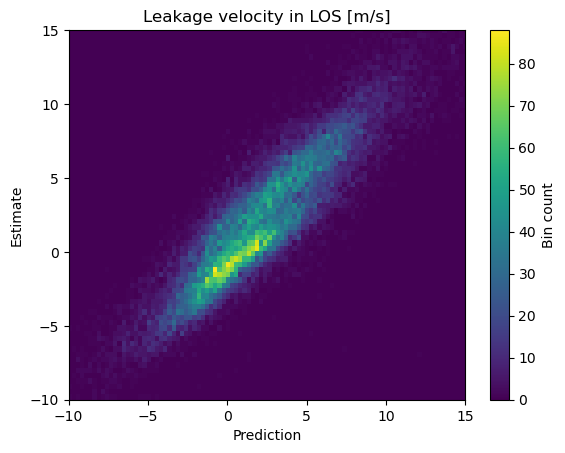

{'bayesianridge_best': [[1.6965574948155606, 0.018917617365346813],
  [0.6075947122337529, 0.006330493964546258]],
 'lightgbm_best': [[1.4092781002490085, 0.016931855477202856],
  [0.7976514026502601, 0.0036824128869723744]],
 'stacked': [[1.3462457072461025, 0.015041901455711354],
  [0.8154682013583644, 0.005548763925790694]]}

In [22]:
plt.hist2d(ML2.y_pred, np.ravel(ML2.y_test.values), bins=(200,200)) #, gridsize=10, cmap='Blues', edgecolors='gray', mincnt=1)
plt.xlim([-10, 15]); plt.ylim([-10, 15])
plt.colorbar(label='Bin count')
plt.title('Leakage velocity in LOS [m/s]')
plt.xlabel('Prediction')
plt.ylabel('Estimate')
plt.show()

ML2.summary